# Imports

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Data Cleaning

In [ ]:
# Loading in dataset
df = pd.read_csv("HR Dataset.csv")

# Dropping redundant features
df = df.drop(columns = ['CF_attrition label', 'CF_current Employee', 'Standard Hours', 'Employee Count', 'emp no', 'Employee Number', 'Over18', 'Daily Rate', 'Monthly Rate'])

## One hot encoding

df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['Gender'] = df['Gender'].map({'Female': 1, 'Male': 0})
df['Over Time'] = df['Over Time'].map({'Yes': 1, 'No': 0})

#Multi category encoding
colnames= ['Business Travel', 'CF_age band', 'Department', 'Education Field', 'Job Role', 'Marital Status', 'Education']
multi_df = df[colnames]
multi_encoded_df = pd.get_dummies(multi_df, dtype=int)

df = df.drop(columns = colnames)
df = pd.concat([df, multi_encoded_df], axis = 1)

df.head(2)

,Attrition,Gender,Over Time,Training Times Last Year,Age,Distance From Home,Environment Satisfaction,Hourly Rate,Job Involvement,Job Level,...,Job Role_Sales Executive,Job Role_Sales Representative,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Education_Associates Degree,Education_Bachelor's Degree,Education_Doctoral Degree,Education_High School,Education_Master's Degree
0,1,1,1,0,41,1,2,94,3,2,...,1,0,0,0,1,1,0,0,0,0
1,0,0,0,3,49,8,3,61,2,2,...,0,0,0,1,0,0,0,0,1,0


# Attrition Analysis and Prediction

Average accuracy is 0.8830835943709383


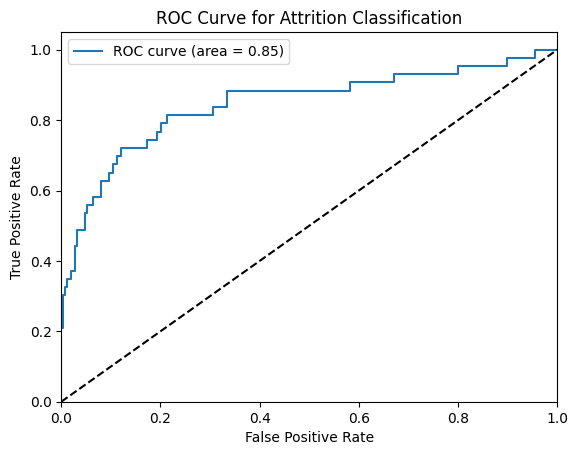

In [ ]:
x = df.drop(columns = ['Attrition'])
y = df['Attrition']

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

accuracy_list = []
roc_auc_list = []

for train_idx, test_idx in kf.split(x):

    model = LogisticRegression()

    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model.fit(x_train, y_train) 

    y_pred_prob = model.predict_proba(x_test)[:, 1]

    y_pred = (y_pred_prob > 0.5).astype(int) 

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

avg_roc_auc = sum(roc_auc_list)/len(roc_auc_list)
avg_accuracy = sum(accuracy_list)/len(accuracy_list)

print('Average accuracy is', avg_accuracy)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % avg_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

## Oversampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

oversampler = SMOTE()
#under = RandomUnderSampler(sampling_strategy=0.5)
model = LogisticRegression()
scaler = StandardScaler()

x = df.drop(columns = ['Attrition'])
y = df['Attrition']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train, y_train = oversampler.fit_resample(x_train, y_train)

model.fit(x_train, y_train) 

y_pred_prob = model.predict_proba(x_test)[:, 1]

y_pred = (y_pred_prob > 0.5).astype(int) 

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_pred)

print('roc', roc_auc)
print('acc', accuracy)

roc 0.8276904964884504
acc 0.7675213675213676


## Feature selection

In [ ]:
model = LogisticRegression()
forward = SequentialFeatureSelector(model, k_features=4, forward=True, verbose=1, scoring="neg_mean_squared_error")

x = df.iloc[:,1:]
y = df['Attrition']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

feature_selector = forward.fit(x_scaled,y)
feat_names = list(feature_selector.k_feature_names_)
print(feat_names)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    1.1s finished
Features: 1/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    1.1s finished
Features: 2/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    1.1s finished
Features: 3/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:   25.3s finished
Features: 4/4['0', '1', '7', '29']


Average accuracy is 0.8396500537659545


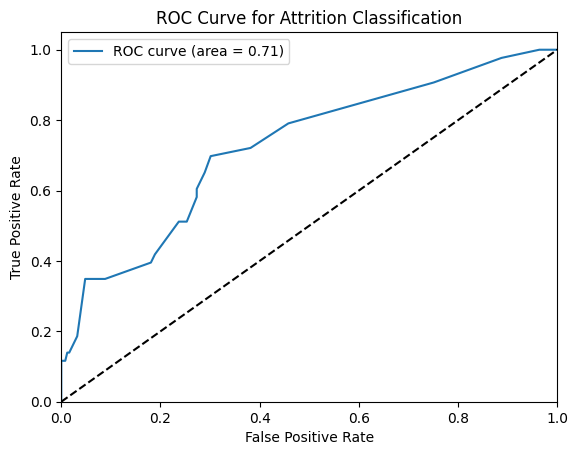

In [ ]:
forward_df = x.iloc[:, [0, 1, 7, 29]]
# features selected by forward selection are gender, over time, job involvement, under 25

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

accuracy_list = []
roc_auc_list = []

for train_idx, test_idx in kf.split(forward_df):

    model = LogisticRegression()

    x_train, x_test = forward_df.iloc[train_idx], forward_df.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model.fit(x_train, y_train) 

    y_pred_prob = model.predict_proba(x_test)[:, 1]

    y_pred = (y_pred_prob > 0.5).astype(int) 

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

avg_roc_auc = sum(roc_auc_list)/len(roc_auc_list)
avg_accuracy = sum(accuracy_list)/len(accuracy_list)

print('Average accuracy is', avg_accuracy)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % avg_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

In [ ]:
model = LogisticRegression()
forward = SequentialFeatureSelector(model, k_features=4, forward=False, verbose=1, scoring="neg_mean_squared_error")

x = df.drop(columns = ['Attrition'])
y = df['Attrition']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

feature_selector = forward.fit(x_scaled,y)
feat_names = list(feature_selector.k_feature_names_)
print(feat_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:  2.0min finished
Features: 57/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:  1.8min finished
Features: 56/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:  2.0min finished
Features: 55/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.7min finished
Features: 54/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.7min finished
Features: 53/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  1.6min finished
Features: 52/4[Parallel(

Average accuracy is 0.851955444387302


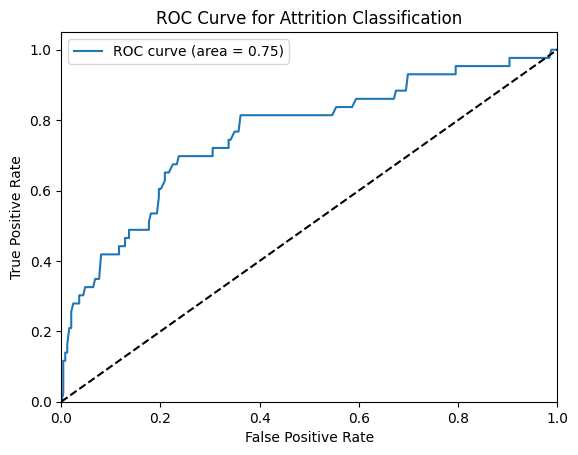

In [ ]:
backward_df = x.iloc[:, [1, 4, 8, 15]]
# features selcted by backward selection are overtime, distance from home, job level, stock option level

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

accuracy_list = []
roc_auc_list = []

for train_idx, test_idx in kf.split(backward_df):

    model = LogisticRegression()

    x_train, x_test = backward_df.iloc[train_idx], backward_df.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model.fit(x_train, y_train) 

    y_pred_prob = model.predict_proba(x_test)[:, 1]

    y_pred = (y_pred_prob > 0.5).astype(int) 

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

avg_roc_auc = sum(roc_auc_list)/len(roc_auc_list)
avg_accuracy = sum(accuracy_list)/len(accuracy_list)

print('Average accuracy is', avg_accuracy)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % avg_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

## PCA Exploration

In [ ]:
#PCA
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
#pca = PCA(n_components=10)
#pca.fit_transform(scaled_df)

pca = PCA()
pca.fit(scaled_df)
pca_data = pca.transform(scaled_df)
per_var = np.round(pca.explained_variance_ratio_, decimals = 3)
labels = [str(x) for x in range(1, len(per_var)+1)]
 
print(labels)

'''
# Finding optimal number of PCs
nrange = np.arange(59)
var_list = []
for n in nrange:
    pca = PCA(n_components = n)
    pca.fit(scaled_df)
    var_list.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nrange,var_list)
plt.xlabel('Number of Components')
plt.ylabel('Explained variance ratio')
plt.title('Components vs. Explained Variance Ratio')
'''

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59']


"\n# Finding optimal number of PCs\nnrange = np.arange(59)\nvar_list = []\nfor n in nrange:\n    pca = PCA(n_components = n)\n    pca.fit(scaled_df)\n    var_list.append(np.sum(pca.explained_variance_ratio_))\n\nplt.figure(figsize=(4,2),dpi=150)\nplt.grid()\nplt.plot(nrange,var_list)\nplt.xlabel('Number of Components')\nplt.ylabel('Explained variance ratio')\nplt.title('Components vs. Explained Variance Ratio')\n"

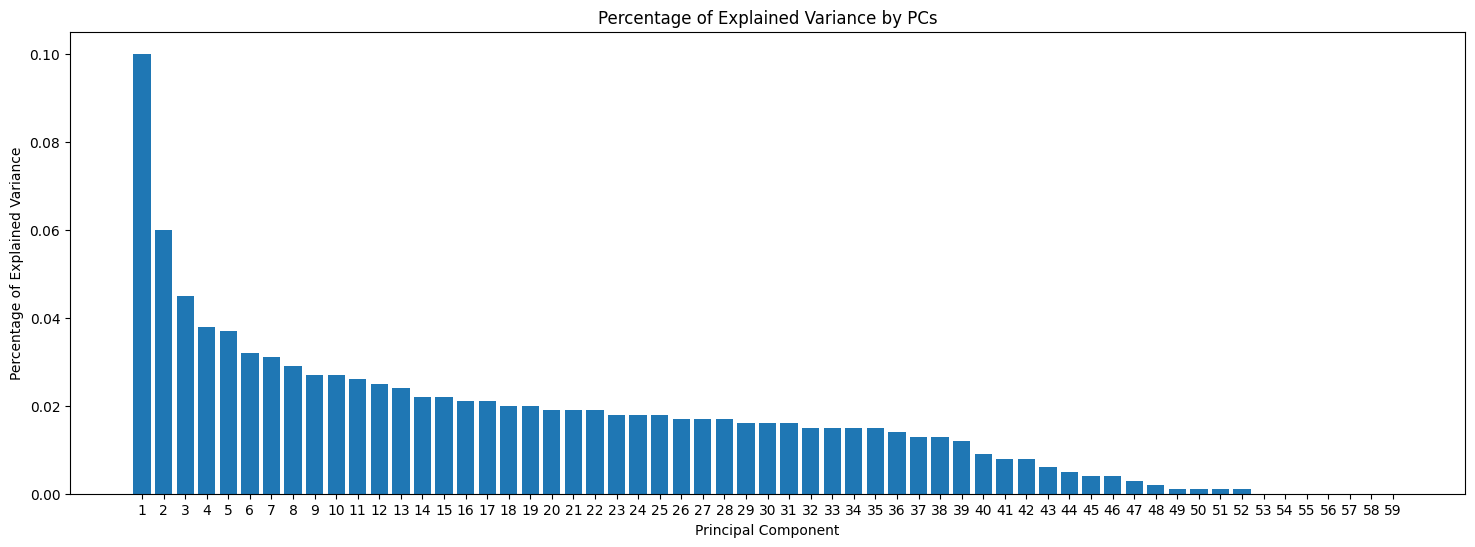

In [ ]:
plt.figure(figsize=(18,6))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Percentage of Explained Variance by PCs')
plt.show()

Text(0.5, 1.0, 'Components vs. Explained Variance Ratio')

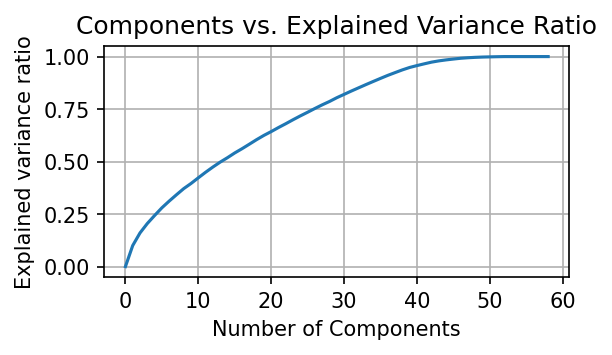

In [ ]:
# Finding optimal number of PCs
nrange = np.arange(59)
var_list = []
for n in nrange:
    pca = PCA(n_components = n)
    pca.fit(scaled_df)
    var_list.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nrange,var_list)
plt.xlabel('Number of Components')
plt.ylabel('Explained variance ratio')
plt.title('Components vs. Explained Variance Ratio')


In [ ]:
for count, variance in enumerate(var_list):
    if variance > 0.8:
        print('The number of PCs that explain 80% of variance is', count)
        break

for count, variance in enumerate(var_list):
    if variance > 0.90:
        print('The number of PCs that explain 90% of variance is',count)
        break

The number of PCs that explain 80% of variance is 29
The number of PCs that explain 90% of variance is 36


In [ ]:
x = df.drop(columns = ['Attrition'])
y = df['Attrition']

Model accuracy for 29 components is 0.852991452991453


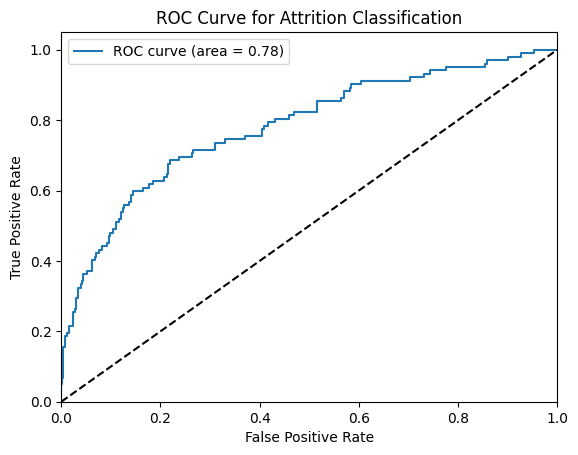

In [ ]:
# Dimensionaity reduction (explain 80% of variance = 29 )

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA(n_components=29)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

model = LogisticRegression(solver = 'lbfgs')
model.fit(x_train_pca, y_train)

y_pred_prob = model.predict_proba(x_test_pca)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int) 

#y_pred = model.predict(x_test_pca)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy for 29 components is', accuracy)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

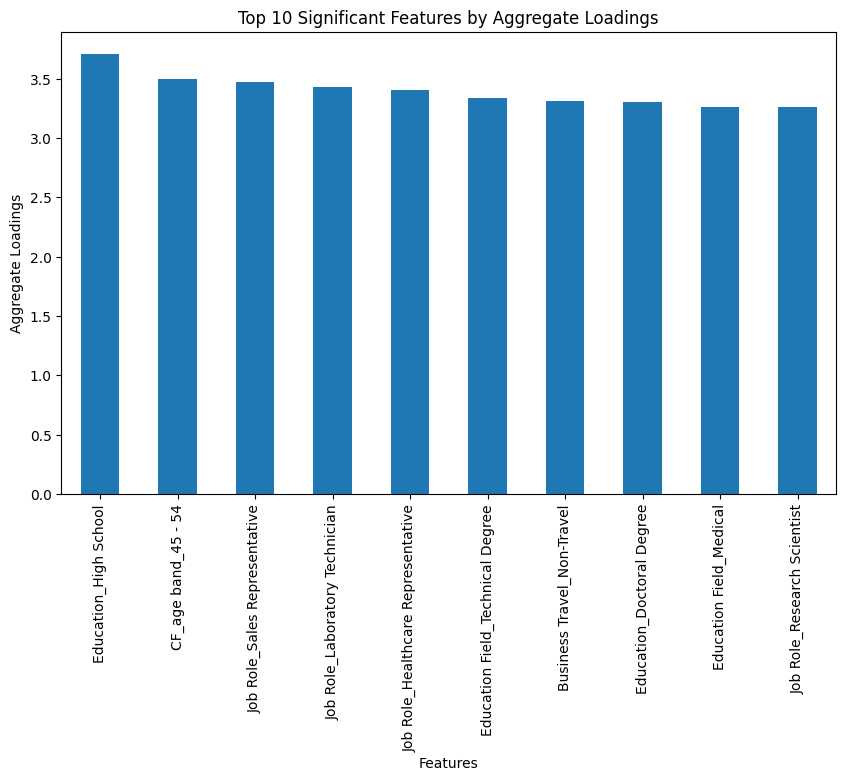

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, index=x.columns, columns=[f'PC{i+1}' for i in range(29)])
aggregate_loadings = loadings_df.abs().sum(axis=1).sort_values(ascending=False)

top_10_features = aggregate_loadings.head(10)

plt.figure(figsize=(10, 6))
top_10_features.plot(kind='bar')
plt.title(f'Top 10 Significant Features by Aggregate Loadings')
plt.xlabel('Features')
plt.ylabel('Aggregate Loadings')
plt.show()

Average accuracy is 0.8317885361634485


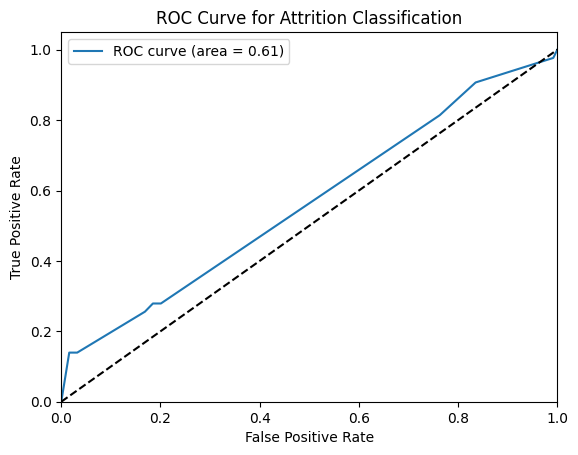

In [ ]:
refined_df = x[['Education_High School', 'CF_age band_45 - 54',
'Job Role_Sales Representative', 'Job Role_Laboratory Technician']]

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

accuracy_list = []
roc_auc_list = []

for train_idx, test_idx in kf.split(refined_df):

    model = LogisticRegression()

    x_train, x_test = refined_df.iloc[train_idx], refined_df.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model.fit(x_train, y_train) 

    y_pred_prob = model.predict_proba(x_test)[:, 1]

    y_pred = (y_pred_prob > 0.5).astype(int) 

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

avg_roc_auc = sum(roc_auc_list)/len(roc_auc_list)
avg_accuracy = sum(accuracy_list)/len(accuracy_list)

print('Average accuracy is', avg_accuracy)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % avg_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

Model accuracy for 36 components is 0.8495726495726496


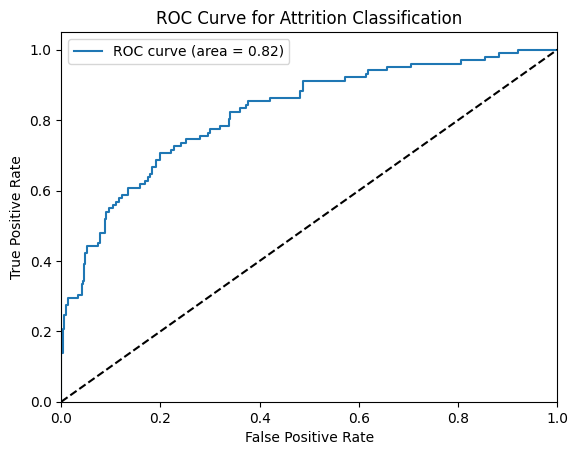

In [ ]:
# Information retention (explain 90% of variance = 36 )

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA(n_components=36)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

model = LogisticRegression(solver = 'lbfgs')
model.fit(x_train_pca, y_train)

y_pred_prob = model.predict_proba(x_test_pca)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int) 

#y_pred = model.predict(x_test_pca)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy for 36 components is', accuracy)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

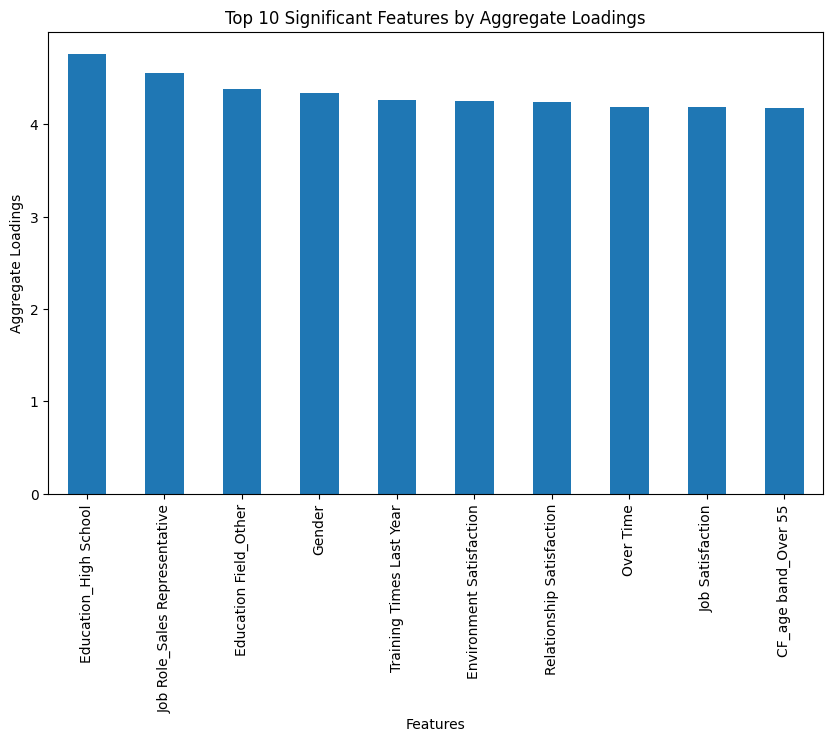

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, index=x.columns, columns=[f'PC{i+1}' for i in range(36)])
aggregate_loadings = loadings_df.abs().sum(axis=1).sort_values(ascending=False)

top_10_features = aggregate_loadings.head(10)

plt.figure(figsize=(10, 6))
top_10_features.plot(kind='bar')
plt.title(f'Top 10 Significant Features by Aggregate Loadings')
plt.xlabel('Features')
plt.ylabel('Aggregate Loadings')
plt.show()

Average accuracy is 0.8379400626490252


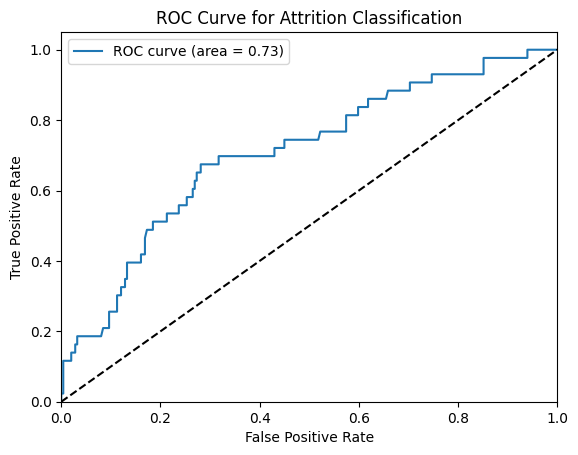

In [ ]:
refined_df = x[['Education_High School', 'Job Role_Sales Representative',
'Education Field_Other', 'Gender', 'Training Times Last Year',
'Environment Satisfaction', 'Relationship Satisfaction', 'Over Time',
'Job Satisfaction', 'CF_age band_Over 55']]

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

accuracy_list = []
roc_auc_list = []

for train_idx, test_idx in kf.split(refined_df):

    model = LogisticRegression()

    x_train, x_test = refined_df.iloc[train_idx], refined_df.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model.fit(x_train, y_train) 

    y_pred_prob = model.predict_proba(x_test)[:, 1]

    y_pred = (y_pred_prob > 0.5).astype(int) 

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

avg_roc_auc = sum(roc_auc_list)/len(roc_auc_list)
avg_accuracy = sum(accuracy_list)/len(accuracy_list)

print('Average accuracy is', avg_accuracy)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % avg_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()

# Employee Segmentation for Targeted HR Policies

In [ ]:
# Scaling the data after one-hot encoding in preparation for K-means

df_encoded = df.copy()

scaler = StandardScaler()
numerical_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()

imputer = SimpleImputer(strategy='mean')
df_encoded[numerical_cols] = imputer.fit_transform(df_encoded[numerical_cols])

scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

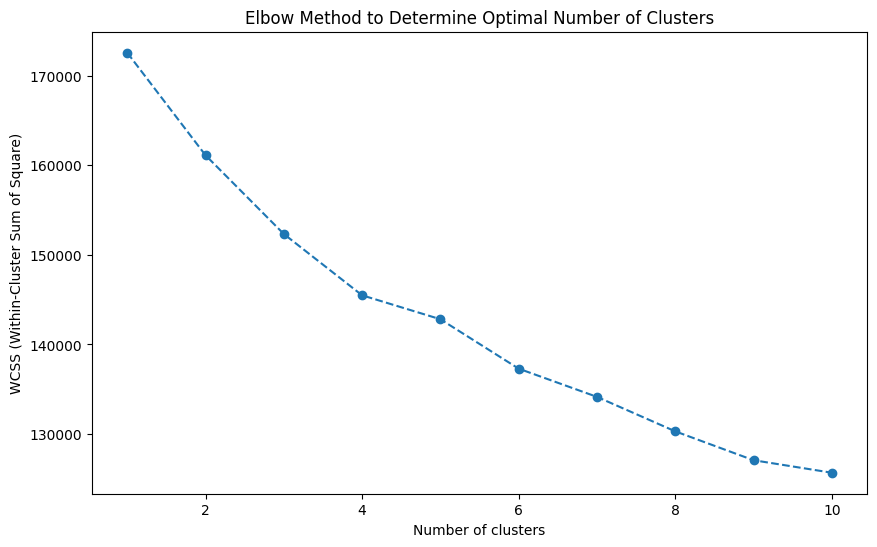

In [ ]:
# Determine optimal number of clusters using Elbow method

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_encoded)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Square)')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.show()

Cluster
0    1482
3     795
2     532
1     116
Name: count, dtype: int64


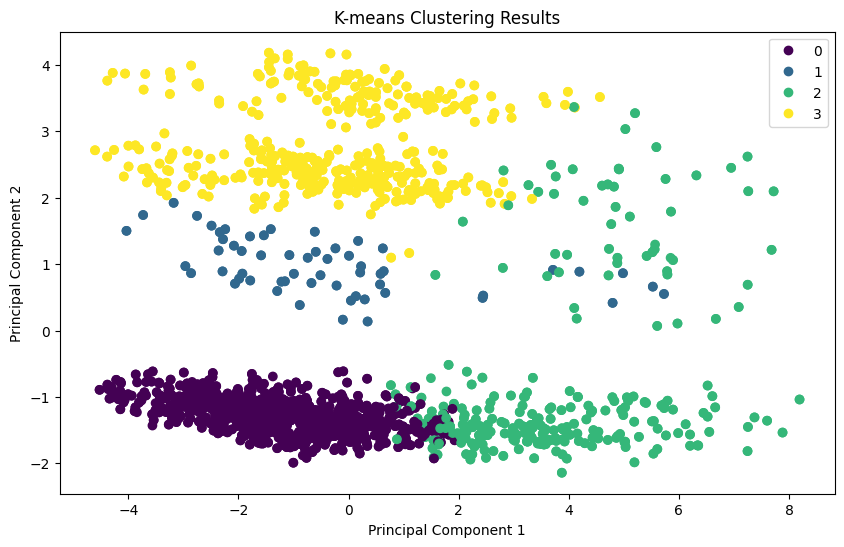

In [ ]:
# K-means with optimal k

optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_encoded['Cluster'] = kmeans.fit_predict(df_encoded)

print(df_encoded['Cluster'].value_counts())

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_encoded.drop(columns=['Cluster']))
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df_encoded['Cluster']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results')
plt.legend(handles=scatter.legend_elements()[0], labels=set(df_pca['Cluster']))
plt.show()

Cluster
0    1482
3     795
2     532
1     116
Name: count, dtype: int64
Cluster 3 Profile:
Numerical Summary:
                                    count      mean           std       min  \
Attrition                           795.0  0.138807  1.108392e+00 -0.449688   
Gender                              795.0  0.012138  1.003023e+00 -0.817078   
Over Time                           795.0  0.017390  1.008840e+00 -0.627841   
Training Times Last Year            795.0  0.066646  9.708438e-01 -2.172710   
Age                                 795.0 -0.210154  8.937497e-01 -2.069965   
Distance From Home                  795.0  0.027960  9.782930e-01 -1.010282   
Environment Satisfaction            795.0 -0.036901  9.818338e-01 -1.577180   
Hourly Rate                         795.0 -0.031207  1.007729e+00 -1.765871   
Job Involvement                     795.0 -0.050373  9.797328e-01 -2.432156   
Job Level                           795.0 -0.037479  5.973129e-01 -0.963087   
Job Satisfaction   

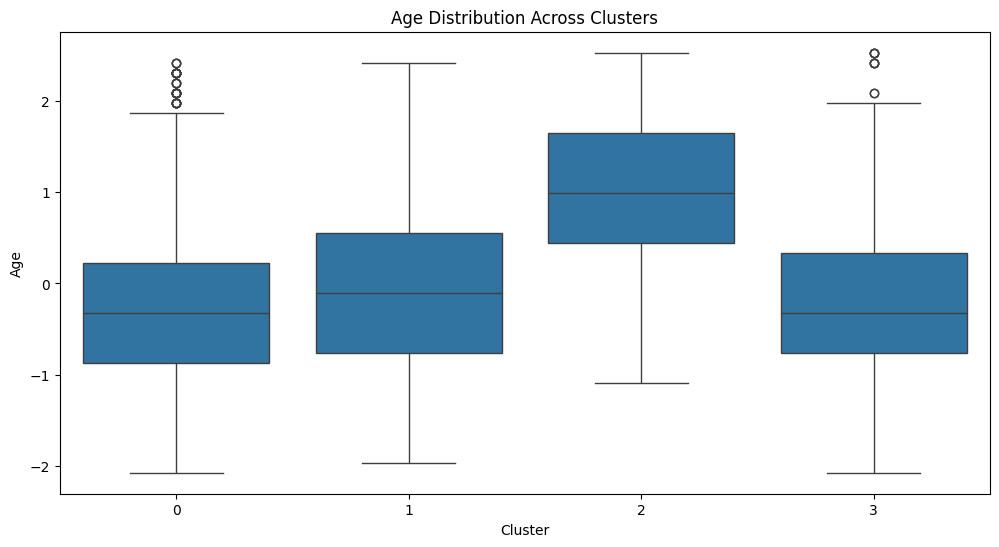

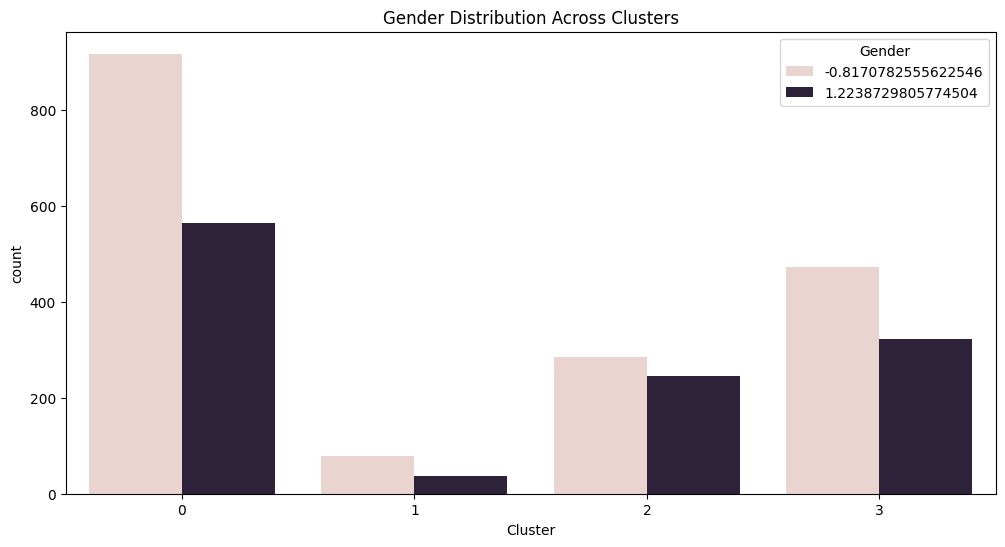

In [ ]:
# Gather summary statistics of each cluster

import seaborn as sns

print(df_encoded['Cluster'].value_counts())

def profile_clusters(df, clusters_col='Cluster'):
    profile = {}
    
    for cluster in df[clusters_col].unique():
        cluster_data = df[df[clusters_col] == cluster]
        
        numerical_summary = cluster_data.describe().transpose()
        
        categorical_summary = {}
        for col in df.select_dtypes(include=['object', 'category']).columns:
            categorical_summary[col] = cluster_data[col].mode()[0], cluster_data[col].value_counts().to_dict()
        
        profile[cluster] = {
            'numerical_summary': numerical_summary,
            'categorical_summary': categorical_summary
        }
    
    return profile

cluster_profiles = profile_clusters(df_encoded)

for cluster, profile in cluster_profiles.items():
    print(f"Cluster {cluster} Profile:")
    print("Numerical Summary:")
    print(profile['numerical_summary'])
    print("\nCategorical Summary:")
    for col, summary in profile['categorical_summary'].items():
        print(f"{col}: Mode - {summary[0]}, Value Counts - {summary[1]}")
    print("\n")

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Age', data=df_encoded)
plt.title('Age Distribution Across Clusters')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='Cluster', hue='Gender', data=df_encoded)
plt.title('Gender Distribution Across Clusters')
plt.show()

# Job Satisfaction and Salary Analysis

In [ ]:
# Variables of Interest
# Satisfaction Variables: 'Job Satisfaction', 'Relationship Satisfaction', 'Environment Satisfaction', 'Work Life Balance'
# Salary Variables: 'Standard Hours', 'Stock Option Level', 'Percent Salary Hike', 'Monthly Income', 'Hourly Rate'
vars_of_interest = ['Attrition', 'Job Satisfaction', 'Relationship Satisfaction', 'Environment Satisfaction', 
                    'Work Life Balance', 'Stock Option Level', 'Percent Salary Hike', 
                    'Monthly Income', 'Hourly Rate']
obj3_subset = df[vars_of_interest]

In [ ]:
obj3_subset.head(10)

,Attrition,Job Satisfaction,Relationship Satisfaction,Environment Satisfaction,Work Life Balance,Stock Option Level,Percent Salary Hike,Monthly Income,Hourly Rate
0,1,4,1,2,1,0,11,5993,94
1,0,2,4,3,3,1,23,5130,61
2,1,3,2,4,3,0,15,2090,92
3,1,3,3,4,3,0,11,2909,56
4,1,2,4,1,3,1,12,3468,40
5,1,4,3,4,2,0,13,3068,79
6,1,1,1,3,2,3,20,2670,81
7,1,3,2,4,3,1,22,2693,67
8,1,3,2,4,3,0,21,9526,44
9,1,3,2,3,2,2,13,5237,94


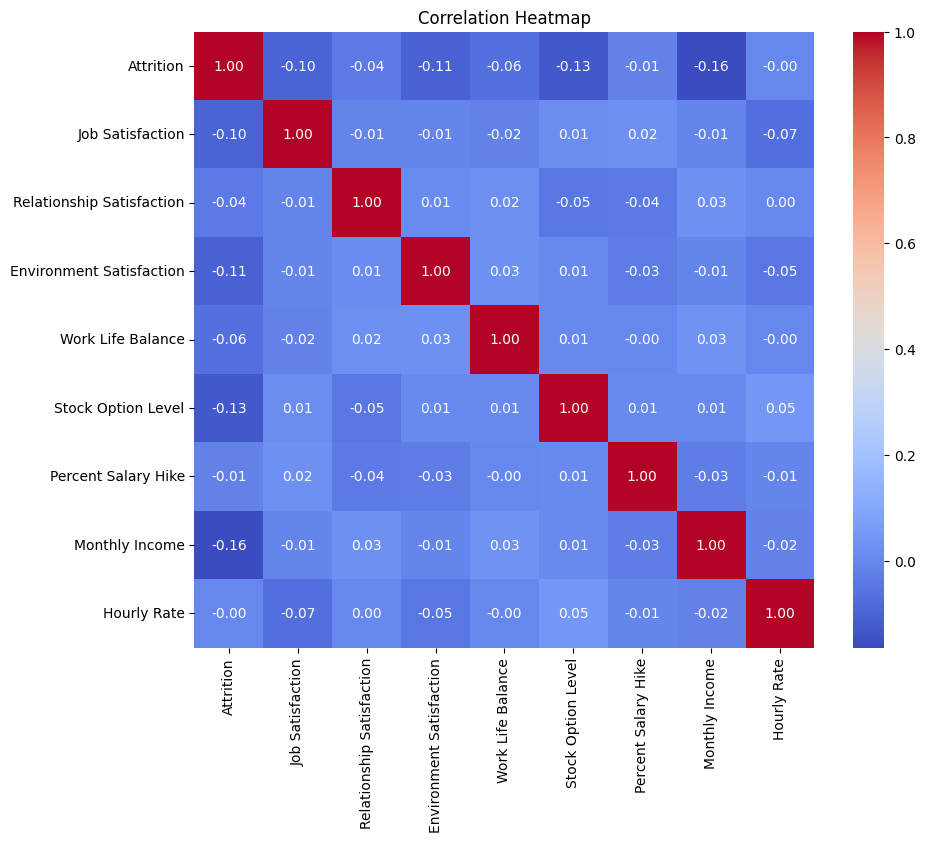

In [ ]:
# Initial Visualization
import seaborn as sns
plt.figure(figsize=(10, 8))
corr_matrix = obj3_subset.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Creating Training and Test Set
from sklearn.model_selection import train_test_split
obj3_response = obj3_subset['Attrition']
obj3_predictors = obj3_subset[vars_of_interest[1:]]
x_train, x_test, y_train, y_test = train_test_split(obj3_predictors, obj3_response, test_size=0.2, random_state=1)

In [ ]:
import statsmodels.api as sm
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)
linear_model = sm.OLS(y_train, x_train)
linear_model = linear_model.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Attrition   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     24.80
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           5.89e-37
Time:                        19:26:02   Log-Likelihood:                -929.32
No. Observations:                2340   AIC:                             1877.
Df Residuals:                    2331   BIC:                             1928.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.6864      0.062     11.150      0.000       0.566       0.807
Job Satisfaction             -0.0366      0.007     -5.439      0.000      -0.050      -0.023
Relationship Satisfaction    -0.0180      0.007     -2.583      0.010      -0.032      -0.004
Environment Satisfaction     -0.0364      0.007     -5.356      0.000      -0.050      -0.023
Work Life Balance            -0.0319      0.011     -3.019      0.003      -0.053      -0.011
Stock Option Level           -0.0613      0.009     -6.887      0.000      -0.079      -0.044
Percent Salary Hike          -0.0021      0.002     -0.999      0.318      -0.006       0.002
Monthly Income            -1.381e-05   1.59e-06     -8.698      0.000   -1.69e-05   -1.07e-05
Hourly Rate                  -0.0002      0.000     -0.575      0.565      -0.001       0.001
==============================================================================
Omnibus:                      559.172   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.447
Skew:                           1.562   Prob(JB):                    3.89e-225
Kurtosis:                       3.918   Cond. No.                     6.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = linear_model.predict(x_test)
y_train_pred = linear_model.predict(x_train)
print(f'test error: {mean_squared_error(y_test, y_pred)}')
print(f'training error: {mean_squared_error(y_train, y_train_pred)}')


test error: 0.13210422263481308
training error: 0.12956296410564225


Test error and training error are similar signifying that the model is likely not overfitting. However, the R-squared value of the model is quite small likely due to the binary nature of the dependent variable.

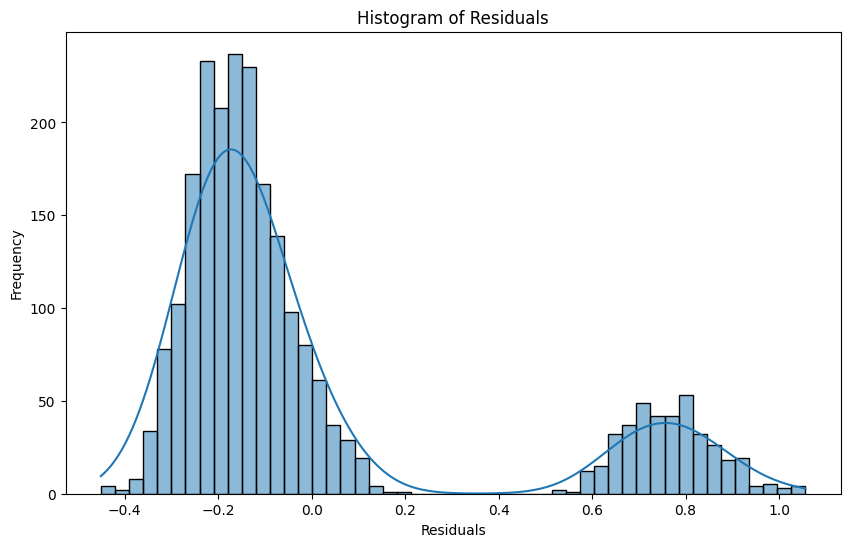

In [ ]:
residuals = y_train - y_train_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Residual Plot would suggest that the relationship between these variables is not linear meaning the linear model is likely not an appropriate model for this subset of variables.

Optimization terminated successfully.
         Current function value: 0.410665
         Iterations 7


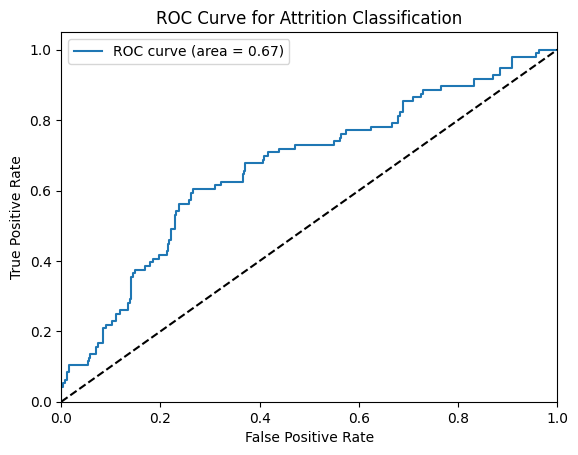

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(obj3_predictors, obj3_response, test_size=0.2, random_state=1)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_const = sm.add_constant(x_train)

logistic_model = sm.Logit(y_train, x_const)
logistic_model = logistic_model.fit()

x_test_const = sm.add_constant(x_test)
y_pred_prob = logistic_model.predict(x_test_const)

y_pred = (y_pred_prob > 0.5).astype(int) 

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
roc_auc = auc(fpr, tpr)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attrition Classification')
plt.legend()
plt.show()


In [ ]:
print(accuracy_score(y_test, y_pred))

0.8376068376068376


In [ ]:
coefficients = logistic_model.params
odds_ratios = np.exp(coefficients)
conf_intervals = logistic_model.conf_int()
predictor_names = ['const','Job Satisfaction', 'Relationship Satisfaction', 'Environment Satisfaction', 
                    'Work Life Balance', 'Stock Option Level', 'Percent Salary Hike', 
                    'Monthly Income', 'Hourly Rate']
results_df = pd.DataFrame({
    'Predictor': predictor_names,
    'Odds Ratio': odds_ratios
})
results_df['Lower CI'] = conf_intervals[0]
results_df['Upper CI'] = conf_intervals[1]
results_df.iloc[1:9]

,Predictor,Odds Ratio,Lower CI,Upper CI
x1,Job Satisfaction,0.735804,-0.419534,-0.194049
x2,Relationship Satisfaction,0.865428,-0.256089,-0.032972
x3,Environment Satisfaction,0.738466,-0.415738,-0.190621
x4,Work Life Balance,0.850452,-0.271671,-0.052305
x5,Stock Option Level,0.650045,-0.561957,-0.299470
x6,Percent Salary Hike,0.940857,-0.176333,0.054405
x7,Monthly Income,0.511778,-0.832948,-0.506780
x8,Hourly Rate,0.974691,-0.139703,0.088433


/tmp/ipykernel_99/1702464388.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = results_df['Odds Ratio'], y = results_df['Predictor'], palette="coolwarm")


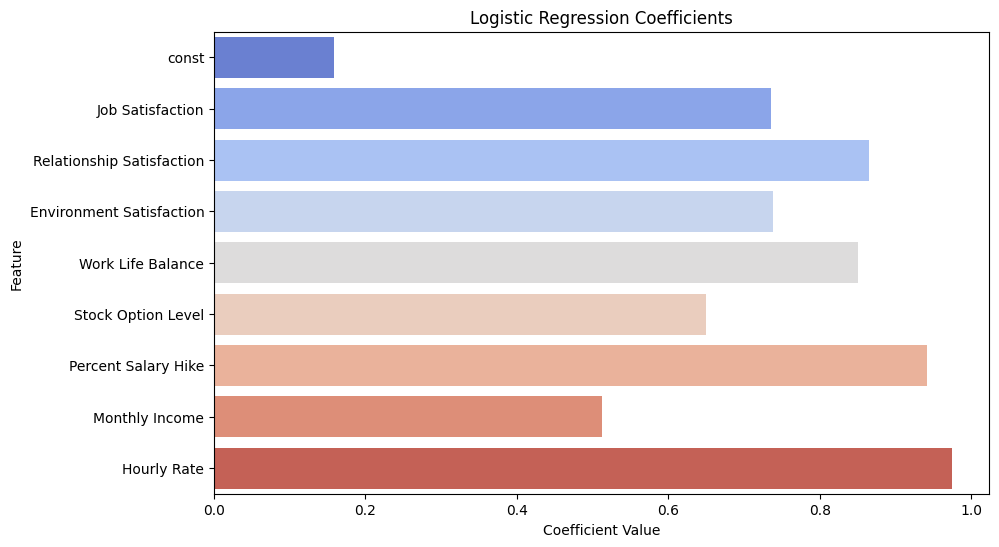

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x = results_df['Odds Ratio'], y = results_df['Predictor'], palette="coolwarm")
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32f995d3-ca40-4951-a1dd-783fa797d6ba' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>